In [10]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

%matplotlib inline

In [11]:
names_text = open("names.txt", "r").read()
words = names_text.splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [12]:
len(words)

32033

In [13]:
chars = ["."] + sorted(list(set("".join(words)) - set(["."])))
ctoi = {c: i for i, c in enumerate(chars)}
itoc = {i: c for i, c in enumerate(chars)}
VOCABULARY_SIZE = len(chars)
VOCABULARY_SIZE

27

In [43]:
def build_dataset(words: list[str], context_length: int = 3) -> tuple[torch.Tensor, torch.Tensor]:
    """Builds bigram dataset from list of words.

    Args:
        words (list[str]): List of words to build dataset from.
        context_length (int, optional): Length of context. Defaults to 3.

    Returns:
        tuple[torch.Tensor, torch.Tensor]: Tuple of input and output tensors.

    example:
        "abc" -> "d" is represented as [0, 1, 2] -> 3
        where [0, 1, 2] in X and 3 in Y
    """
    X, Y = [], []
    for word in words:
        context = [0] * context_length
        for c in word:
            idx = ctoi[c]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    return torch.tensor(X), torch.tensor(Y)


X, Y = build_dataset(words)
X.shape, Y.shape

(torch.Size([196113, 3]), torch.Size([196113]))

In [ ]:
# E01: Hyperparameters
EMBEDDING_DIMS = 10
CONTEXT_LENGTH = 3
HIDDEN_LAYER = 100


build_dataset(words, context_length=CONTEXT_LENGTH)


class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.sequential = nn.Sequential(
            nn.Embedding(VOCABULARY_SIZE, EMBEDDING_DIMS),
            nn.Flatten(),
            nn.Linear(EMBEDDING_DIMS * CONTEXT_LENGTH, HIDDEN_LAYER),
            nn.Tanh(),
            nn.Linear(HIDDEN_LAYER, VOCABULARY_SIZE),
        )

        self.losses = []

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.sequential(X)

    def train(self, X: torch.Tensor, Y: torch.Tensor, epochs: int, lr: float, batch_size: int, decay: float = 0.9999):
        for epoch in range(epochs):
            # select mini-batch
            batch_idx = torch.randint(0, len(X), (batch_size,))
            X_train = X[batch_idx]
            y_train = Y[batch_idx]

            logits = self.forward(X_train)
            loss = F.cross_entropy(logits, y_train)
            # loss += 0.01 * (self.sequential[2].weight ** 2).mean()  # L2 regularization

            self.zero_grad()
            loss.backward()

            # update parameters
            with torch.no_grad():
                for param in self.parameters():
                    if param.grad is not None:
                        param -= lr * param.grad

            lr *= decay  # decay learning rate
            self.losses.append(loss.item())

            # print(f"{epoch=}, loss={self.loss.item()}")

    def predict_next_token(self, text: str) -> str:
        context = [ctoi[c] for c in text[-CONTEXT_LENGTH:]]
        X = torch.tensor([context])
        logits = self.forward(X)
        probs = F.softmax(logits, dim=1)

        idx = torch.multinomial(probs, 1)
        c = itoc[int(idx)]
        return c

    def evaluate(self, X: torch.Tensor, Y: torch.Tensor) -> float:
        logits = self.forward(X)
        return F.cross_entropy(logits, Y).item()

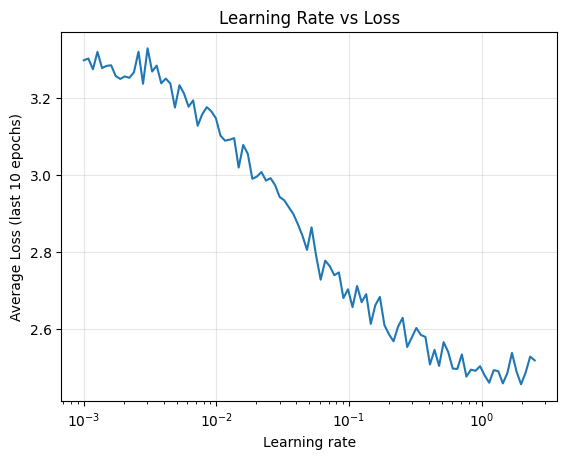

In [82]:
# Determine the reasonable learning rate
# Test different learning rates and plot the final loss
lre = torch.linspace(-3, 0.4, 100)
lrs = 10**lre
losses = []

for lr in lrs:
    mlp = MLP()
    mlp.train(X, Y, epochs=100, lr=float(lr), batch_size=256, decay=1.0)
    # Take the average of last 10 losses to reduce noise
    losses.append(sum(mlp.losses[-10:]) / 10)

plt.plot(lrs, losses)
plt.xlabel("Learning rate")
plt.ylabel("Average Loss (last 10 epochs)")
plt.xscale("log")
plt.title("Learning Rate vs Loss")
plt.grid(True, alpha=0.3)
plt.show()

2.231736421585083

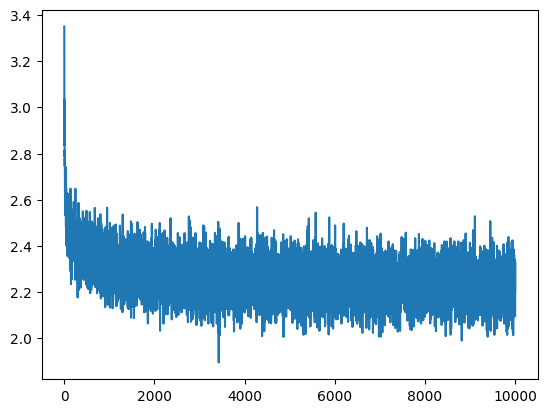

In [83]:
# without decay
mlp = MLP()
mlp.train(X, Y, epochs=10000, lr=1, batch_size=256, decay=1.0)

plt.plot(mlp.losses)
mlp.evaluate(X, Y)

2.177715301513672

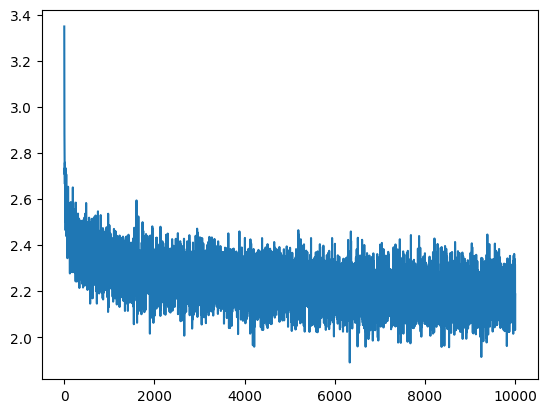

In [87]:
# with decay
mlp = MLP()
mlp.train(X, Y, epochs=10000, lr=1, batch_size=256, decay=0.9999)

plt.plot(mlp.losses)
mlp.evaluate(X, Y)

In [ ]:
# E02: Analysis of initialization

# (1) Calculate the theoretical loss with perfectly uniform probabilities
# If probabilities are perfectly uniform, each of the 27 characters has probability 1/27
# The loss is -log(1/27) = log(27)
import math

theoretical_uniform_loss = math.log(VOCABULARY_SIZE)
print(f"Theoretical loss with uniform probabilities: {theoretical_uniform_loss:.4f}")

# Check the actual initial loss
mlp_test = MLP()
initial_loss = mlp_test.evaluate(X, Y)
print(f"Actual initial loss: {initial_loss:.4f}")
print(f"Difference: {abs(initial_loss - theoretical_uniform_loss):.4f}")


# (2) Tune the initialization to get a starting loss closer to uniform
# The key is to initialize the final layer with smaller weights so logits are closer to 0
# When logits are all ~0, softmax gives uniform probabilities


class MLPBetterInit(nn.Module):
    def __init__(self):
        super().__init__()

        self.embedding = nn.Embedding(VOCABULARY_SIZE, EMBEDDING_DIMS)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(EMBEDDING_DIMS * CONTEXT_LENGTH, HIDDEN_LAYER)
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(HIDDEN_LAYER, VOCABULARY_SIZE)

        # Better initialization: make the final layer output closer to 0
        # This makes the logits more uniform, leading to uniform probabilities
        self.linear2.weight.data *= 0.01  # Scale down the weights
        self.linear2.bias.data *= 0.0  # Zero out the biases

        self.losses = []

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        x = self.embedding(X)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        return x

    def train(self, X: torch.Tensor, Y: torch.Tensor, epochs: int, lr: float, batch_size: int, decay: float = 0.9999):
        for epoch in range(epochs):
            # select mini-batch
            batch_idx = torch.randint(0, len(X), (batch_size,))
            X_train = X[batch_idx]
            y_train = Y[batch_idx]

            logits = self.forward(X_train)
            loss = F.cross_entropy(logits, y_train)

            self.zero_grad()
            loss.backward()

            # update parameters
            with torch.no_grad():
                for param in self.parameters():
                    if param.grad is not None:
                        param -= lr * param.grad

            lr *= decay  # decay learning rate
            self.losses.append(loss.item())

    def predict_next_token(self, text: str) -> str:
        context = [ctoi[c] for c in text[-CONTEXT_LENGTH:]]
        X = torch.tensor([context])
        logits = self.forward(X)
        probs = F.softmax(logits, dim=1)

        idx = torch.multinomial(probs, 1)
        c = itoc[int(idx)]
        return c

    def evaluate(self, X: torch.Tensor, Y: torch.Tensor) -> float:
        logits = self.forward(X)
        return F.cross_entropy(logits, Y).item()


# Test the better initialization
mlp_better = MLPBetterInit()
better_initial_loss = mlp_better.evaluate(X, Y)
print(f"\nWith better initialization:")
print(f"Theoretical loss with uniform probabilities: {theoretical_uniform_loss:.4f}")
print(f"Initial loss: {better_initial_loss:.4f}")
print(f"Difference: {abs(better_initial_loss - theoretical_uniform_loss):.4f}")
print(
    f"\nImprovement: {abs(initial_loss - theoretical_uniform_loss):.4f} -> {abs(better_initial_loss - theoretical_uniform_loss):.4f}"
)

Theoretical loss with uniform probabilities: 3.2958
Actual initial loss: 3.3372
Difference: 0.0414

With better initialization:
Theoretical loss with uniform probabilities: 3.2958
Initial loss: 3.2960
Difference: 0.0002

Improvement: 0.0414 -> 0.0002


2.1840662956237793

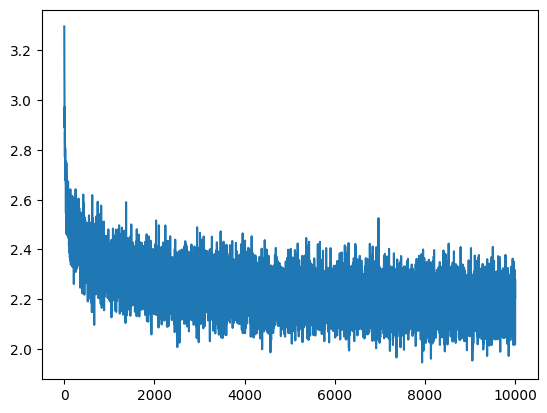

In [71]:
mlp = MLPBetterInit()
mlp.train(X, Y, epochs=10000, lr=0.5, batch_size=256, decay=0.9999)

plt.plot(mlp.losses)
mlp.evaluate(X, Y)